In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utils as ut

In [64]:
# this string must be passed during the execution of gillespie_test.exe
data_dir = '../data/chem_evol_e_log/'

In [69]:
params = dict()

# LV parameters
params['process_type'] = 'chem_evole'
#params['delta0'] = 1
params['eta0'] = 1
params['alpha0'] = 0.01
params['M'] = 200
params['mut_rate'] = 0.00002
params['alpha_max'] = params['alpha0']*params['M']*2
params['delta_alpha'] = params['alpha_max']/16


# Gillespie parameters
params['end_cond'] = 'time'
params['max_steps'] = 600000000
params['traj_step'] = params['max_steps']/2000
n_states = int(params['alpha_max']/params['delta_alpha'])
#params['init_state'] = np.ones(n_states) * params['M'] / n_states # Initial condition
params['init_state'] = np.zeros(n_states)
params['init_state'][-1] = params['M']
params['r_start'] = 0
params['N_realizations'] = 15

In [70]:
ut.write_params(params, data_dir, 'param.txt')

### Import

In [3]:
data_dir = '../data/chem_evol_e/'
params = ut.read_params(data_dir+'param.txt')
n_states = int(params['alpha_max']/params['delta_alpha'])

In [39]:
traj, labels = ut.read_traj(data_dir+'traj1.txt')

In [40]:
labels

['Time',
 's0',
 's1',
 's2',
 's3',
 's4',
 's5',
 's6',
 's7',
 's8',
 's9',
 's10',
 's11',
 's12',
 's13',
 's14',
 's15']

In [41]:
N_traj = traj[:,1:].sum(axis=1)
alphas = np.linspace(params['delta_alpha'], params['alpha_max'], n_states)
av_alpha_traj = np.sum(traj[:,1:]*alphas, axis=1) / N_traj
std_alpha_traj = np.sqrt(np.sum(traj[:,1:]*alphas**2, axis=1) / N_traj - av_alpha_traj**2)

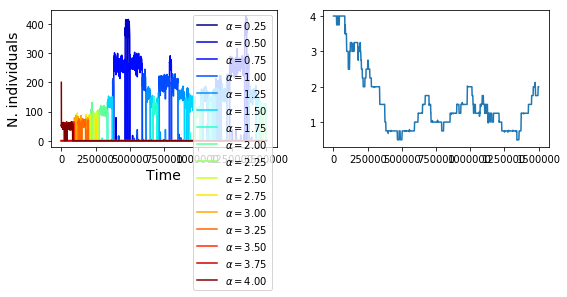

In [42]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,3.5))
colors = plt.cm.jet(np.linspace(0,1,n_states))
#xlim = [0,len(traj[:,0])]
#xlim = [0,1000]
#ax1.set_ylim([0,300])
ax1.set_xlabel('Time',fontsize=14)
ax1.set_ylabel('N. individuals',fontsize=14)
#ax1.set_xlim(xlim)
for i in range(len(labels)-1):
    ax1.plot(traj[:,0], traj[:,1:][:,i], c=colors[i], label=r'$\alpha=%3.2f$'%((i+1)*params['delta_alpha']))
ax1.legend(fontsize=10)

#ax2.set_xlim(xlim)
ax2.plot(traj[:,0], av_alpha_traj)
ax2.fill_between(traj[:,0], av_alpha_traj-std_alpha_traj/2, av_alpha_traj+std_alpha_traj/2)
plt.tight_layout()
#plt.savefig('../plots/LV/traj.png', dpi=200, transparent=True)

In [43]:
cumul_av_alpha = np.zeros(len(av_alpha_traj))
for i in range(len(labels)-1):
    cumul_av_alpha = np.row_stack((cumul_av_alpha, cumul_av_alpha[-1] + traj[:,1:][:,i]))

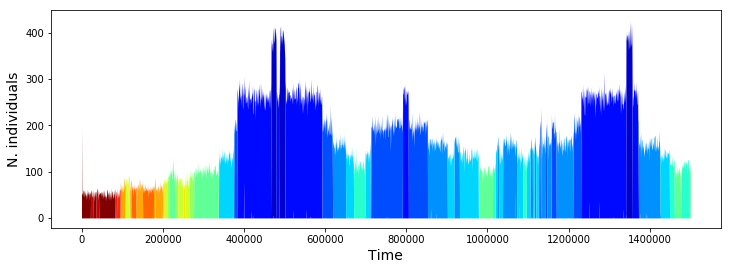

In [44]:
fig, (ax1) = plt.subplots(1,1,figsize=(12,4))
colors = plt.cm.jet(np.linspace(0,1,n_states))
#xlim = [32000,34000]
#plt.ylim([0,200])
ax1.set_xlabel('Time',fontsize=14)
ax1.set_ylabel('N. individuals',fontsize=14)
#ax1.set_xlim(xlim)
for i in range(len(labels)-1):
    ax1.fill_between(traj[:,0], cumul_av_alpha[i], cumul_av_alpha[i+1], color=colors[i],lw=0)
#ax1.legend(fontsize=10)

plt.savefig('chem_evol.png',dpi=200)

In [61]:
alphas = np.linspace(params['delta_alpha'], params['alpha_max'], n_states)
av_av_alpha = np.zeros(len(av_alpha_traj))
av_times = np.zeros(len(av_alpha_traj))
params['N_realizations'] = 120
final_dist = np.array([])
snap_times_frac = np.array([0.6,0.7,0.8,0.9,1])
snap_times = snap_times_frac * int(len(av_alpha_traj)-1)
for i in range(int(params['N_realizations'])):
    traj, labels = ut.read_traj(data_dir+'traj'+str(i)+'.txt')
    N_traj = traj[:,1:].sum(axis=1)
    av_alpha_traj = np.sum(traj[:,1:]*alphas, axis=1) / N_traj
    #plt.plot(av_alpha_traj)
    #final_dist.append(av_alpha_traj[int(len(av_alpha_traj)*0.9)])
    av_av_alpha += av_alpha_traj/params['N_realizations']
    av_times += traj[:,0]/params['N_realizations']

In [63]:
av_alpha_traj[snap_times]

IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
np.row_stack()

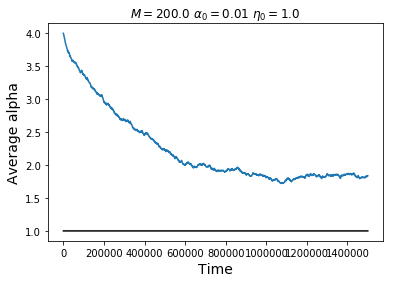

In [32]:
plt.xlabel('Time',fontsize=14)
plt.ylabel('Average alpha',fontsize=14)
plt.title("$M=$"+str(params['M'])+r" $\alpha_0=$"+str(params['alpha0'])+r" $\eta_0=$"+str(params['eta0']))
plt.plot(av_times, av_av_alpha)
plt.plot(av_times, np.ones(len(traj[:,0]))*np.sqrt(params['M']*params['alpha0']/2), c='black')
plt.savefig('av_alpha.png', dpi=200)

In [34]:
alphas = np.linspace(params['delta_alpha'], params['alpha_max'], int( params['alpha_max']/params['delta_alpha']))
alphas

array([0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75,
       3.  , 3.25, 3.5 , 3.75, 4.  ])

In [25]:
def mut_p_inv_ratio(Nts, c):
    e1 = (c+1)/c*(Nts/2 + 1 - c)
    return np.exp(e1)

def c_f(a1, a2, a0):
    return (a1 + a0)/(a2 + a0)

def Nts_f(M, a1, a2, a0):
    return M * a0*(a1-a2)/a1/a2**2

In [26]:
i = 0
Nts = Nts_f(params['M'], alphas[i+1], alphas[i], params['alpha0'])
c = c_f(alphas[i+1], alphas[i], params['alpha0'])
print(alphas[i], alphas[i+1], mut_p_inv_ratio(Nts, c))

0.25 0.5 41220.74106537532


In [27]:
dist = np.array([1])
for i in range(len(alphas)-1):
    Nts = Nts_f(params['M'], alphas[i+1], alphas[i], params['alpha0'])
    c = c_f(alphas[i+1], alphas[i], params['alpha0'])
    dist = np.append(dist, dist[-1]*mut_p_inv_ratio(Nts, c))

(array([0.03333333, 0.23333333, 0.26666667, 0.5       , 0.6       ,
        0.53333333, 0.2       , 0.2       , 0.2       , 0.33333333,
        0.2       , 0.1       , 0.2       , 0.2       , 0.2       ]),
 array([0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75,
        3.  , 3.25, 3.5 , 3.75, 4.  ]),
 <a list of 15 Patch objects>)

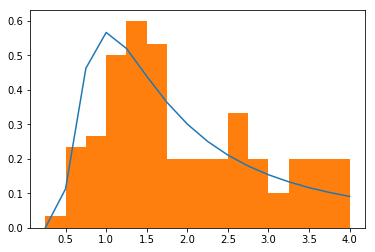

In [50]:
plt.plot(alphas, dist/dist.sum()/(alphas[1]-alphas[0]))
bins = np.linspace(params['delta_alpha'], params['alpha_max'], int(params['alpha_max']/params['delta_alpha']))
plt.hist(final_dist, bins=bins, density=True)

In [30]:
(alphas*dist/dist.sum()).sum()

1.7861649061286033